# Обработка видео
Классификация действий по видео


## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

## Загрузка и распаковка датасета KTH

In [4]:
if 0:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if 0:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

## Подготовка датасета для классификации

In [5]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        #cls_idx = cls
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [6]:
random.shuffle(dataset)
ds_train = dataset[:200]
ds_test = dataset[200:400]

print('Dataset train (subset):', len(ds_train))
print('Dataset test (subset):', len(ds_test))

Dataset train (subset): 200
Dataset test (subset): 200


## Визуализация кадра из видео

videodata shape: (490, 120, 160, 3)


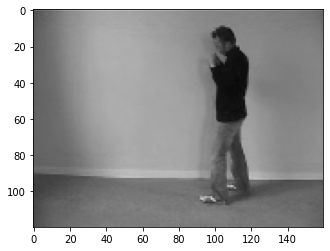

In [7]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

## Визуализация "движения"

motion shape: (489, 120, 160, 1)


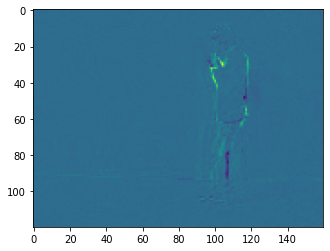

In [8]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

## Создание модели CNN

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [10]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 489, 120, 160, 1)
Output shape: (1, 6)


## Подготовка к обучению

In [11]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 4

#model.compile(
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.Adam(LEARNING_RATE)

writer = tf.summary.create_file_writer('logs/exp1')

## Цикл обучения модели

In [12]:
def prepare_video(fpath, label):
    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255.
    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
    x = motion[None, ...]
    y = np.array(label)[None, ...]
    return x, y

In [ ]:
global_step = 0
for ep in range(NUM_EPOCHS):
    # for iter, (fpath, label) in enumerate(dataset):
    for iter in range(len(ds_train)): 
        (fpath, label) = ds_train[iter]
        train_x, train_y = prepare_video(fpath, label)
        (fpath, label) = ds_test[iter]
        test_x, test_y = prepare_video(fpath, label)

        # Forward
        with tf.GradientTape() as tape:
            embs = model(train_x)
            loss_value = loss(train_y ,embs)
            
        # Backward
        grads = tape.gradient(loss_value, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables))

        pred = model(test_x)
        loss_value_test = loss(test_y ,embs)

        #loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep:2.0f}/{NUM_EPOCHS}][{iter:3.0f}/{len(ds_train)}] Loss_train = {loss_value:2.4f} | Loss_test = {loss_value_test:2.4f}')

            with writer.as_default():
                tf.summary.scalar('Loss_train', loss_value, global_step)
                tf.summary.scalar('Loss_test', loss_value_test, global_step)

        global_step += 1

[ 0/10][  0/200] Loss_train = 1.7926 | Loss_test = 1.7927
[ 0/10][ 10/200] Loss_train = 1.8467 | Loss_test = 1.7143
[ 0/10][ 20/200] Loss_train = 1.8255 | Loss_test = 1.8050
[ 0/10][ 30/200] Loss_train = 1.7884 | Loss_test = 1.8055
[ 0/10][ 40/200] Loss_train = 1.7596 | Loss_test = 1.7880
[ 0/10][ 50/200] Loss_train = 1.8241 | Loss_test = 1.8241
[ 0/10][ 60/200] Loss_train = 1.8325 | Loss_test = 1.8325
[ 0/10][ 70/200] Loss_train = 1.8264 | Loss_test = 1.8261
[ 0/10][ 80/200] Loss_train = 1.7293 | Loss_test = 1.7867
[ 0/10][ 90/200] Loss_train = 1.7132 | Loss_test = 1.8130
[ 0/10][100/200] Loss_train = 1.8619 | Loss_test = 1.7507


## TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## Тестирование обученной модели

In [ ]:
fpath, cls_true = random.choice(ds_test)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])